<h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spacing: 1px; background-color: #f6f5f5; color :#6666ff; border-radius: 200px 200px; text-align:center">Efficient Networks: SOTA Image Classification</h1>

<center><img src="https://1.bp.blogspot.com/-oNSfIOzO8ko/XO3BtHnUx0I/AAAAAAAAEKk/rJ2tHovGkzsyZnCbwVad-Q3ZBnwQmCFsgCEwYBhgL/s640/image3.png" width="500" alt="Weights & Biases" /></center><br>

<p style = "font-family: garamond; font-size: 20px; font-style: normal; border-radius: 10px 10px; text-align:center">Convolutional Neural Networks are commonly developed at a fixed resource budget,and then scaled up for better accuracy if more resources are available. Efficient Nets propose a new scaling method that uniformly scales all dimensions of depth/width/resolution using a simple yet highly effective compound coefficient. We demonstrate the effectiveness of this method on scaling up MobileNets and ResNet. To go even further, we use neural architecture search to design a new baseline network and scale it up to obtain a family of models,called EfficientNets, which achieve much better accuracy and efficiency than previous ConvNets.</p>

<p p style = "font-family: garamond; font-size:40px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">What are we discussing today? </p>
 <p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#006699; border-radius: 10px 10px; text-align:center">Efficient Nets<br>
 Ranger optimizer <br>
 GridMask Augmentation <br>
 Pytorch Lightning <br>
 Stratified K-Fold with PL ⚡️ <br>
 Weights and Biases for Experiment Tracking

<p p style = "font-family: garamond; font-size:35px; font-style: normal;background-color: #f6f5f5; color :#ff0066; border-radius: 10px 10px; text-align:center">Upvote the kernel if you find it insightful!</p>

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">TIMM Pytorch Models</p>

<p style = "font-family: garamond; font-size: 20px; font-style: normal; border-radius: 10px 10px; text-align:center">PyTorch Image Models (timm) is a collection of image models, layers, utilities, optimizers, schedulers, data-loaders / augmentations, and reference training / validation scripts that aim to pull together a wide variety of SOTA models with ability to reproduce ImageNet training results.<br><br>
Using timm we will create the Efficient Net model for our problem statement. We will be using the Efficient Net B0 variant. </p>

In [ ]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')

# <center><img src="https://i.imgur.com/gb6B4ig.png" width="400" alt="Weights & Biases" /></center><br>
<p style = "font-family: garamond; font-size: 20px; font-style: normal; border-radius: 10px 10px; text-align:center">Wandb is a developer tool for companies turn deep learning research projects into deployed software by helping teams track their models, visualize model performance and easily automate training and improving models.
We will use their tools to log hyperparameters and output metrics from your runs, then visualize and compare results and quickly share findings with your colleagues.<br><br>We'll be using this to train our K Fold Cross Validation and gain better insights about our training. <br><br></p>

![img](https://i.imgur.com/BGgfZj3.png)

In [ ]:
!pip install --upgrade -q wandb
!pip install -q pytorch-lightning

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Import Libraries</p>

In [ ]:
# Hide Warning
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Python Libraries
from tqdm import tqdm
from collections import defaultdict
import pandas as pd
import numpy as np
import os
import random
import glob
import math


# Visualizations
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import plotly.express as px
%matplotlib inline
sns.set(style="whitegrid")

# Utilities and Metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

# Pytorch 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.optimizer import Optimizer, required 


# Pytorch Lightning
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning import Callback
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import WandbLogger

# Pytorch Image Models
import timm

# Image Augmentation Library
import albumentations
from albumentations.pytorch import ToTensorV2
from albumentations.core.transforms_interface import DualTransform
from albumentations.augmentations import functional as AF

# Weights and Biases Tool
import wandb
wandb.login()

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Define Configurations/Parameters</p>

In [ ]:
params = {
    'seed': 42,
    'model': 'efficientnet_b0',
    'size' : 480,
    'inp_channels': 1,
    'lr': 1e-3,
    'weight_decay': 1e-6,
    'batch_size': 32,
    'num_workers' : 8,
    'epochs': 5,
    'out_features': 1,
    'name': 'CosineAnnealingLR',
    'T_max': 10,
    'min_lr': 1e-6,
    'nfolds': 5,
    'precision': 16
}

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Define Seed for Reproducibility</p>

In [ ]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(params['seed'])

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Load Train and Test</p>

In [ ]:
train_dir = ('../input/seti-breakthrough-listen/train')
test_dir = ('../input/seti-breakthrough-listen/test')
train_df = pd.read_csv('../input/seti-breakthrough-listen/train_labels.csv')
test_df = pd.read_csv('../input/seti-breakthrough-listen/sample_submission.csv')

In [ ]:
def return_filpath(name, folder=train_dir):
    path = os.path.join(folder, name[0], f'{name}.npy')
    return path

In [ ]:
train_df['image_path'] = train_df['id'].apply(lambda x: return_filpath(x))
test_df['image_path'] = test_df['id'].apply(lambda x: return_filpath(x, folder=test_dir))
train_df.head()

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">GridMask Data Augmentation</p>

<center><img src="https://pic3.zhimg.com/v2-2fbfeb0fd08f902de0fabe11ca5edac9_1440w.jpg?source=172ae18b" width="1000" alt="GridMAsk" /></center><br>

<p style = "font-family: garamond; font-size: 20px; font-style: normal; border-radius: 10px 10px; text-align:center">GridMask Augmentation utilizes information removal to achieve state-of-the-art results in a variety of computer vision tasks. There are limitations to existing information dropping algorithms whereas GridMask is simple and yet very effective.<br><br> It is based on the deletion of regions of the input image. Extensive experiments show that this method outperforms the latest AutoAugment,which is way more computationally expensive due to the use of reinforcement learning to find the best policies. On the
ImageNet dataset for recognition, COCO2017 object detection, and on Cityscapes dataset for semantic segmentation, GridMask improves performance over baselines. <br><br>The extensive experiments manifest the effectiveness and generality of the new method.<br><br> Avoiding excessive deletion and reservation
of continuous regions is the core requirement for information dropping methods. <br><br>The reason is twofold intuitively.<br>1. On the one hand, excessively deleting one or a few regions may lead to complete object removal and context information be removed as well. Thus remaining information is not enough to be classified and the image is more like noisy data.<br>2. On the other hand, excessive preserving regions could make some objects untouched. They are trivial images that may lead to a reduction of the networks robustness. <br><br>
Thus designing a simple method that reduces the
chance of causing these two problems becomes essential.

In [ ]:
class GridMask(DualTransform):

    def __init__(self, num_grid=3, fill_value=0, rotate=0, mode=0, always_apply=False, p=0.5):
        super(GridMask, self).__init__(always_apply, p)
        if isinstance(num_grid, int):
            num_grid = (num_grid, num_grid)
        if isinstance(rotate, int):
            rotate = (-rotate, rotate)
        self.num_grid = num_grid
        self.fill_value = fill_value
        self.rotate = rotate
        self.mode = mode
        self.masks = None
        self.rand_h_max = []
        self.rand_w_max = []

    def init_masks(self, height, width):
        if self.masks is None:
            self.masks = []
            n_masks = self.num_grid[1] - self.num_grid[0] + 1
            for n, n_g in enumerate(range(self.num_grid[0], self.num_grid[1] + 1, 1)):
                grid_h = height / n_g
                grid_w = width / n_g
                this_mask = np.ones((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)
                for i in range(n_g + 1):
                    for j in range(n_g + 1):
                        this_mask[
                             int(i * grid_h) : int(i * grid_h + grid_h / 2),
                             int(j * grid_w) : int(j * grid_w + grid_w / 2)
                        ] = self.fill_value
                        if self.mode == 2:
                            this_mask[
                                 int(i * grid_h + grid_h / 2) : int(i * grid_h + grid_h),
                                 int(j * grid_w + grid_w / 2) : int(j * grid_w + grid_w)
                            ] = self.fill_value
                
                if self.mode == 1:
                    this_mask = 1 - this_mask

                self.masks.append(this_mask)
                self.rand_h_max.append(grid_h)
                self.rand_w_max.append(grid_w)

    def apply(self, image, mask, rand_h, rand_w, angle, **params):
        h, w = image.shape[:2]
        mask = AF.rotate(mask, angle) if self.rotate[1] > 0 else mask
        mask = mask[:,:,np.newaxis] if image.ndim == 3 else mask
        image *= mask[rand_h:rand_h+h, rand_w:rand_w+w].astype(image.dtype)
        return image

    def get_params_dependent_on_targets(self, params):
        img = params['image']
        height, width = img.shape[:2]
        self.init_masks(height, width)

        mid = np.random.randint(len(self.masks))
        mask = self.masks[mid]
        rand_h = np.random.randint(self.rand_h_max[mid])
        rand_w = np.random.randint(self.rand_w_max[mid])
        angle = np.random.randint(self.rotate[0], self.rotate[1]) if self.rotate[1] > 0 else 0

        return {'mask': mask, 'rand_h': rand_h, 'rand_w': rand_w, 'angle': angle}

    @property
    def targets_as_params(self):
        return ['image']

    def get_transform_init_args_names(self):
        return ('num_grid', 'fill_value', 'rotate', 'mode')

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Image Augmentation</p>

In [ ]:
def get_train_transforms():
    return albumentations.Compose(
        [
            albumentations.Resize(params['size'],params['size']),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.Rotate(limit=180, p=0.7),
            albumentations.RandomBrightness(limit=0.6, p=0.5),
            albumentations.Cutout(
                num_holes=10, max_h_size=12, max_w_size=12,
                fill_value=0, always_apply=False, p=0.5
            ),
            albumentations.ShiftScaleRotate(
                shift_limit=0.25, scale_limit=0.1, rotate_limit=0
            ),
            albumentations.OneOf([
                GridMask(num_grid=3, mode=0, rotate=15),
                GridMask(num_grid=3, mode=2, rotate=15),
                                ], p=0.7),
            ToTensorV2(p=1.0),
        ]
    )

def get_valid_transforms():
    return albumentations.Compose(
        [
            albumentations.Resize(params['size'],params['size']),
            ToTensorV2(p=1.0)
        ]
    )

def get_test_transforms():
        return albumentations.Compose(
            [
                albumentations.Resize(params['size'],params['size']),
                ToTensorV2(p=1.0)
            ]
        )

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Custom Dataset</p>

In [ ]:
class SETIDataset(Dataset):
    def __init__(self, images_filepaths, targets, transform=None):
        self.images_filepaths = images_filepaths
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = np.load(image_filepath).astype(np.float32)
        image = np.vstack(image).transpose((1, 0))
            
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        else:
            image = image[np.newaxis,:,:]
            image = torch.from_numpy(image).float()
        
        label = torch.tensor(self.targets[idx]).float()
        return image, label

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Custom Callback for Viewing Predictions in W&B <br> Code Credit <a href = 'https://www.kaggle.com/ayuraj/use-pytorch-lightning-with-weights-and-biases'>Ayush Thakur </a></p>


In [ ]:
class ImagePredictionLogger(Callback):
    def __init__(self, val_samples, num_samples=32):
        super().__init__()
        self.num_samples = num_samples
        self.val_imgs, self.val_labels = val_samples
        
    def on_validation_epoch_end(self, trainer, pl_module):
        val_imgs = self.val_imgs.to(device=pl_module.device)
        val_labels = self.val_labels.to(device=pl_module.device)
        logits = pl_module(val_imgs)
        preds = torch.argmax(logits, -1)
        trainer.logger.experiment.log({
            "examples":[wandb.Image(x, caption=f"Pred:{pred}, Target:{y}") 
                           for x, pred, y in zip(val_imgs[:self.num_samples], 
                                                 preds[:self.num_samples], 
                                                 val_labels[:self.num_samples])]
            }, commit=False)

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Ranger Optimizer with Gradient Centralization</p>

<p style = "font-family: garamond; font-size: 20px; font-style: normal; border-radius: 10px 10px; text-align:center"> The Ranger optimizer combines two very new Optimizers into a single optimizer:- <br><br>1. RAdam - which is a variant of the Adam stochastic optimizer that introduces a term to rectify the variance of the adaptive learning rate. <br>2.Lookahead - which iteratively updates two sets of weights. Intuitively, the algorithm chooses a search direction by looking ahead at the sequence of fast weights generated by another optimizer.<br><br>RAdam provides the best base for an optimizer to build on as it leverages a dynamic rectifier to adjust the adaptive momentum of Adam based on the variance. LookAhead provides a breakthrough in robust and stable exploration during the entirety of training. <br><br>
📍 What is Gradient Centralization? <br><br> GC is a new optimization technique, namely gradient centralization which operates directly on gradients by centralizing the gradient vectors to have zero mean. GC can be viewed as a projected gradient descent method with a constrained loss function. We show that GC can regularize both the weight space and output feature space so that it can boost the generalization performance of DNNs.<br><br> Moreover, GC improves the Lipschitzness of the loss function and its gradient so that the training process becomes more efficient and stable. GC is very simple to implement and can be easily embedded into existing gradient based DNN optimizers with only one line of code. It can also be directly used to fine-tune the pre-trained DNNs.

In [ ]:
# https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer

class Ranger(Optimizer):

    def __init__(self, params, lr=1e-3,                       # lr
                 alpha=0.5, k=6, N_sma_threshhold=5,           # Ranger options
                 betas=(.95, 0.999), eps=1e-5, weight_decay=0,  # Adam options
                 # Gradient centralization on or off, applied to conv layers only or conv + fc layers
                 use_gc=True, gc_conv_only=False
                 ):

        # parameter checks
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        if not lr > 0:
            raise ValueError(f'Invalid Learning Rate: {lr}')
        if not eps > 0:
            raise ValueError(f'Invalid eps: {eps}')


        # prep defaults and init torch.optim base
        defaults = dict(lr=lr, alpha=alpha, k=k, step_counter=0, betas=betas,
                        N_sma_threshhold=N_sma_threshhold, eps=eps, weight_decay=weight_decay)
        super().__init__(params, defaults)

        # adjustable threshold
        self.N_sma_threshhold = N_sma_threshhold

        # look ahead params

        self.alpha = alpha
        self.k = k

        # radam buffer for state
        self.radam_buffer = [[None, None, None] for ind in range(10)]

        # gc on or off
        self.use_gc = use_gc

        # level of gradient centralization
        self.gc_gradient_threshold = 3 if gc_conv_only else 1

        print(
            f"Ranger optimizer loaded. \nGradient Centralization usage = {self.use_gc}")
        if (self.use_gc and self.gc_gradient_threshold == 1):
            print(f"GC applied to both conv and fc layers")
        elif (self.use_gc and self.gc_gradient_threshold == 3):
            print(f"GC applied to conv layers only")

    def __setstate__(self, state):
        print("set state called")
        super(Ranger, self).__setstate__(state)

    def step(self, closure=None):
        loss = None

        # Evaluate averages and grad, update param tensors
        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()

                if grad.is_sparse:
                    raise RuntimeError(
                        'Ranger optimizer does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]  # get state dict for this param

                if len(state) == 0:  

                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)

                    # look ahead weight storage now in state dict
                    state['slow_buffer'] = torch.empty_like(p.data)
                    state['slow_buffer'].copy_(p.data)

                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                # begin computations
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # GC operation for Conv layers and FC layers
                if grad.dim() > self.gc_gradient_threshold:
                    grad.add_(-grad.mean(dim=tuple(range(1, grad.dim())), keepdim=True))

                state['step'] += 1

                # compute variance mov avg
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                # compute mean moving avg
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                buffered = self.radam_buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * \
                        state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma
                    if N_sma > self.N_sma_threshhold:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (
                            N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay']
                                     * group['lr'], p_data_fp32)

                # apply lr
                if N_sma > self.N_sma_threshhold:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size *
                                         group['lr'], exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)

                p.data.copy_(p_data_fp32)

                # integrated look ahead...
                # we do it at the param level instead of group level
                if state['step'] % group['k'] == 0:
                    # get access to slow param tensor
                    slow_p = state['slow_buffer']
                    # (fast weights - slow weights) * alpha
                    slow_p.add_(self.alpha, p.data - slow_p)
                    # copy interpolated weights to RAdam param tensor
                    p.data.copy_(slow_p)

        return loss

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Pytorch Lightning DataModule</p>

# <center>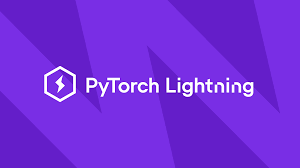</center>


<p style = "font-family: garamond; font-size: 20px; font-style: normal; border-radius: 10px 10px; text-align:center"> A datamodule is a shareable, reusable class that encapsulates all the steps needed to process data. A datamodule encapsulates the five steps involved in data processing in PyTorch:<br>1. Download / tokenize / process.<br>2. Clean and (maybe) save to disk.<br>3. Load inside Dataset.<br>4. Apply transforms (rotate, tokenize, etc…).<br>5. Wrap inside a DataLoader.<br><br>
📍 Why do I need a DataModule?<br>In normal PyTorch code, the data cleaning/preparation is usually scattered across many files. This makes sharing and reusing the exact splits and transforms across projects impossible.<br>Datamodules are for you if you ever asked the questions:<br>1. what splits did you use?<br>2. what transforms did you use?<br>3. what normalization did you use?<br>4. how did you prepare/tokenize the data?<br><br> To summarize: A DataModule is simply a collection of a train_dataloader, val_dataloader(s), test_dataloader(s) along with the matching transforms and data processing/downloads steps required.

In [ ]:
class DataModule(pl.LightningDataModule):

    def __init__(self, train_data, valid_data, test_data):
        super().__init__()
        self.train_data = train_data
        self.valid_data = valid_data
        self.test_data = test_data
        
    def setup(self, stage=None):
        self.train_dataset = SETIDataset(
        images_filepaths=self.train_data['image_path'].values,
        targets=self.train_data['target'].values,
        transform=get_train_transforms()
            )
        
        self.val_dataset = SETIDataset(
        images_filepaths=self.valid_data['image_path'].values,
        targets=self.valid_data['target'].values,
        transform=get_valid_transforms()
            )

        self.test_dataset = SETIDataset(
        images_filepaths = self.test_data['image_path'].values,
        targets = self.test_data['target'].values,
        transform = get_test_transforms()
            )

    def train_dataloader(self):
        return DataLoader(
        self.train_dataset,
        batch_size=params['batch_size'],
        shuffle=True,
        num_workers=params['num_workers'],
        pin_memory=True
            )

    def val_dataloader(self):
        return DataLoader(
        self.val_dataset,
        batch_size=params['batch_size'],
        shuffle=False,
        num_workers=params['num_workers'],
        pin_memory=True
            )

    def test_dataloader(self):
        return DataLoader(
        self.test_dataset, batch_size=params['batch_size'],
        shuffle=False, num_workers=params['num_workers'],
        pin_memory=True
            )

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Pytorch Lightning Module</p>
<center>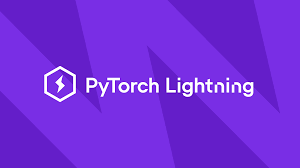</center><br>

<p style = "font-family: garamond; font-size: 20px; font-style: normal; border-radius: 10px 10px; text-align:center"> A LightningModule organizes your PyTorch code into 5 sections<br>1. Computations (init).<br>2. Train loop (training_step)<br>3. Validation loop (validation_step)<br>4. Test loop (test_step)<br>5. Optimizers (configure_optimizers)<br><br>
A LightningModule is a torch.nn.Module but with added functionality. 

In [ ]:
class Trainer(pl.LightningModule):

    def __init__(self, model_name=params['model'],out_features=params['out_features'],
                 inp_channels=params['inp_channels'],pretrained=True):
        super().__init__()
        
        self.model = timm.create_model(model_name, pretrained=pretrained,
                                       in_chans=inp_channels)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, out_features, bias=True) 
        
        self.criterion = nn.BCEWithLogitsLoss()
                
    def forward(self, x):
        output = self.model(x)
        return output


    def training_step(self, batch, batch_idx):

        x, y = batch
        output = self(x)
        labels = y.unsqueeze(1)
        loss = self.criterion(output, labels)
        
        try:
            auc=roc_auc_score(labels.detach().cpu(), output.sigmoid().detach().cpu()) 

            self.log("auc", auc, on_step= True, prog_bar=True, logger=True)
            self.log("Train Loss", loss, on_step= True,prog_bar=True, logger=True)
        except:
            pass

        return {"loss": loss, "predictions": output, "labels": labels}

    def training_epoch_end(self, outputs):

        preds = []
        labels = []
        
        for output in outputs:
            
            preds += output['predictions']
            labels += output['labels']

        labels = torch.stack(labels)
        preds = torch.stack(preds)

        train_auc=roc_auc_score(labels.detach().cpu(), preds.sigmoid().detach().cpu())
        self.log("mean_train_auc", train_auc, prog_bar=True, logger=True)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        labels = y.unsqueeze(1)
        loss = self.criterion(output, labels)
        self.log('val_loss', loss, on_step= True, prog_bar=True, logger=True)
        return {"predictions": output, "labels": labels}
      

    def validation_epoch_end(self, outputs):

        preds = []
        labels = []
        
        for output in outputs:
            preds += output['predictions']
            labels += output['labels']

        labels = torch.stack(labels)
        preds = torch.stack(preds)

        val_auc=roc_auc_score(labels.detach().cpu(), preds.sigmoid().detach().cpu())
        self.log("val_auc", val_auc, prog_bar=True, logger=True)
        

    def test_step(self, batch, batch_idx):
        x = batch        
        output = self(x).sigmoid()
        return output   

    def configure_optimizers(self):

        optimizer = Ranger(self.parameters(), lr = params['lr'])

        scheduler = CosineAnnealingLR(optimizer,
                              T_max=params['T_max'],
                              eta_min=params['min_lr'],
                              last_epoch=-1)

        return dict(
          optimizer=optimizer,
          lr_scheduler=scheduler
        )

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Pytorch Lightning Trainer</p>

# <center>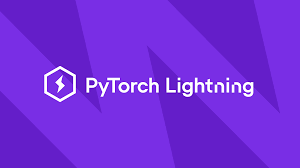</center>

<p style = "font-family: garamond; font-size: 20px; font-style: normal; border-radius: 10px 10px; text-align:center"> Once you’ve organized your PyTorch code into a LightningModule, the Trainer automates everything else.<br><br>📍 This abstraction achieves the following:<br><br>1. You maintain control over all aspects via PyTorch code without an added abstraction.<br>2. The trainer uses best practices embedded by contributors and users from top AI labs such as Facebook AI Research, NYU, MIT, Stanford, etc…<br>3. The trainer allows overriding any key part that you don’t want automated.<br><br>
📍 Under the hood<br>
Under the hood, the Lightning Trainer handles the training loop details for you, some examples include:<br>1. Automatically enabling/disabling grads<br>2. Running the training, validation and test dataloaders<br>3. Calling the Callbacks at the appropriate times<br>4. Putting batches and computations on the correct devices<br><br>
📍 The code below applies Stratified K-Fold with PL ⚡️



In [ ]:
skf = StratifiedKFold(n_splits=params['nfolds'], shuffle=True, random_state=params['seed'])
train_df["fold"] = -1

model = Trainer()

for fold, (_, val_idx) in enumerate(skf.split(train_df["id"], train_df["target"])):
    train_df.loc[val_idx, "fold"] = fold
    
    if fold != 0:
        continue
    
    wandb_logger = WandbLogger(project='SETI-Lightning', 
                           config={'competetion': 'SETI', '_wandb_kernel':'tang'},
                           group='EffNet', 
                           job_type='train',
                           name = f'Fold{fold}')
    
    print(f"{'='*38} Fold: {fold} {'='*38}")
    
    
    data_module = DataModule(
      train_df[train_df['fold']!=fold],
      train_df[train_df['fold']==fold], 
      train_df[train_df['fold']==fold], 
    )
    
    data_module.setup()
    val_samples = next(iter(data_module.val_dataloader()))
    
    early_stopping_callback = EarlyStopping(monitor='val_auc',mode="max", patience=2)
    
    checkpoint_callback = ModelCheckpoint(
      dirpath="checkpoints",
      filename="best-checkpoint-fold{fold}-val_auc{val_auc:.3f}",
      save_top_k=params['epochs'],
      verbose=True,
      monitor="val_auc",
      mode="max"
    )
    
    trainer = pl.Trainer(
      gpus= 1,
      checkpoint_callback=checkpoint_callback,
      callbacks=[early_stopping_callback,
                       ImagePredictionLogger(val_samples)],
      max_epochs=params['epochs'],
      precision=params['precision'],
      progress_bar_refresh_rate=1,
      logger=wandb_logger
    )
    
    trainer.fit(model, data_module)

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Single Fold Results</p>

<p style = "font-family: garamond; font-size: 25px; font-style: normal; border-radius: 10px 10px; text-align:center">We are able to achieve a Validation AUC score of 97.50! in just 5 Epochs<br><br> Weights & Biases provides us with such easy to use interface and tools to keep a track of our Evaluation metrics like training and validation loss and Roc along with other resources like Gpu usage<br><br> Let's take a look at some of our training and GPU Utilization graphs along with Predictions</p>

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center"><a href = 'https://wandb.ai/tanishqgautam/SETI-Lightning?workspace=user-tanishqgautam'>Check out the Weights and Biases Dashboard here $\rightarrow$ </a></p>

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Image Predictions</p><br>

<center><img src="https://i.imgur.com/FYMjXSS.png" width="1500" alt="metrics" /></center>

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Single Fold Metrics</p><br>

<center><img src="https://i.imgur.com/Wgxk9rf.png" width="1500" alt="metrics" /></center>

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">Validation Loss per Epoch</p><br>

<center><img src="https://i.imgur.com/RsfAt2g.png" width="1500" alt="metrics" /></center>

<p p style = "font-family: garamond; font-size:30px; font-style: normal;background-color: #f6f5f5; color :#6666ff; border-radius: 10px 10px; text-align:center">GPU Utilization</p><br>

<center><img src="https://i.imgur.com/nHhgP1e.png" width="1500" alt="metrics" /></center>